In [13]:
import numpy as np
import string
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

np.random.seed(1011)
np.set_printoptions(suppress=True)

In [14]:
with open('dataset.txt', 'r') as file:
    text = file.read()

In [25]:
text

'In natural language processing (NLP), word embedding is a term used for the representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.Word embeddings can be obtained using a set of language modeling and feature learning techniques where words or phrases from the vocabulary are mapped to vectors of real numbers.Methods to generate this mapping include neural networks,dimensionality reduction on the word co-occurrence matrix, probabilistic models, explainable knowledge base method, and explicit representation in terms of the context in which words appear.Word and phrase embeddings, when used as the underlying input representation, have been shown to boost the performance in NLP tasks such as syntactic parsing and sentiment analysis.'

In [15]:
def tokenize(input_string):
    '''
    Tokenize the training data. Punctuation is removed and 
    each words in the training data is split as a elements in a list.
    '''
    tokens = ''.join([char 
                        for char in input_string.lower() 
                        if char not in string.punctuation])
    return tokens.split(' ')

def text_dictionary(tokens):
    '''
    Create two dictionary named word_to_idx and idx_to_word.
    In word_to_idx each word is as key with a assigned unique id as value.
    idx_to_word is same as word_to_idx except that id is as key and word as value
    '''
    word_to_idx = {}
    idx_to_word = {}

    # turn the tokens into set before looping to remove duplicate words
    for i, token in enumerate(set(tokens)):
        word_to_idx[token] = i
        idx_to_word[i] = token

    return word_to_idx, idx_to_word

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def one_hot_encode(id, vocab_size):
    '''
    Transform a word into one-hot representation
    '''
    # A list with the same length as vocab_size is initialize with all zeros elements
    # except value of the corresponding index of word is 1
    res = [0] * vocab_size
    res[id] = 1
    return res

def generate_training_data(tokens, word_to_idx, window):
    '''
    Generate x, y dataset for our skip-gram model.
    x and y are both the one-hot representation of words.
    '''
    x, y = [], []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            x.append(one_hot_encode(word_to_idx[tokens[i]], len(word_to_idx)))
            y.append(one_hot_encode(word_to_idx[tokens[j]], len(word_to_idx)))

    return np.asarray(x), np.asarray(y)

In [16]:
tokens = tokenize(text)
word_to_idx, idx_to_word = text_dictionary(tokens)
x, y = generate_training_data(tokens, word_to_idx, 2)

x.shape, y.shape

((546, 88), (546, 88))

In [24]:
tokens[:10]

['in',
 'natural',
 'language',
 'processing',
 'nlp',
 'word',
 'embedding',
 'is',
 'a',
 'term']

Forward:

&nbsp;&nbsp;&nbsp;&nbsp; $A_1 = X W_1$ <br>
&nbsp;&nbsp;&nbsp;&nbsp; $A_2 = A_1 W_2$ <br>
&nbsp;&nbsp;&nbsp;&nbsp; $Z = Softmax(A_2)$

Backward: 
##### &nbsp;&nbsp;&nbsp;&nbsp; $\frac{dL}{dW_2} = \frac{dL}{dZ} \frac{dZ}{dA_2} \frac{dA_2}{dW_2} = (Z - Y) * A_1$
##### &nbsp;&nbsp;&nbsp;&nbsp; $\frac{dL}{dW_1} = \frac{dL}{dZ} \frac{dZ}{dA_2} \frac{dA_2}{dA_1} \frac{dA_1}{dW_1} = (Z - Y) * W_2 * X$


In [18]:
class SkipGram:

    def __init__(self, vocab_size, n_embedding):
        self.loss_history = []
        self.vocab_size = vocab_size
        self.n_embedding = n_embedding

    def init_weights(self):
        self.w1 = np.random.randn(self.vocab_size, self.n_embedding)
        self.w2 = np.random.randn(self.n_embedding, self.vocab_size)

    def softmax(self, z):
        # minus z by the max of z for number stability
        # keepdims is set to true to unchange the dimensional of array
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, x):
        self.a1 = np.dot(x, self.w1)
        self.a2 = np.dot(self.a1, self.w2)
        self.z = self.softmax(self.a2)
        return self.z

    def backward(self, x, y):
        self.da2 = self.z - y
        self.dw2 = np.dot(self.a1.T, self.da2)
        self.da1 = np.dot(self.da2, self.w2.T)
        self.dw1 = np.dot(x.T, self.da1)

    def update(self, lr): # SGD
        self.w1 -= lr * self.dw1
        self.w2 -= lr * self.dw2

    def loss(self, y, m): # cross_entropy
        self.loss_history.append(- np.sum(np.log(self.z) * y) / m)

    def fit(self, x, y, epochs, lr):
        m = x.shape[0]
        self.init_weights()
        for _ in range(epochs):
            self.forward(x)
            self.backward(x, y)
            self.update(lr)
            self.loss(y, m)

    def predict(self, x):
        return self.forward(x)

In [19]:
epochs = 50
lr = 0.05

model = SkipGram(x.shape[1], 10)
model.fit(x, y, epochs, lr)

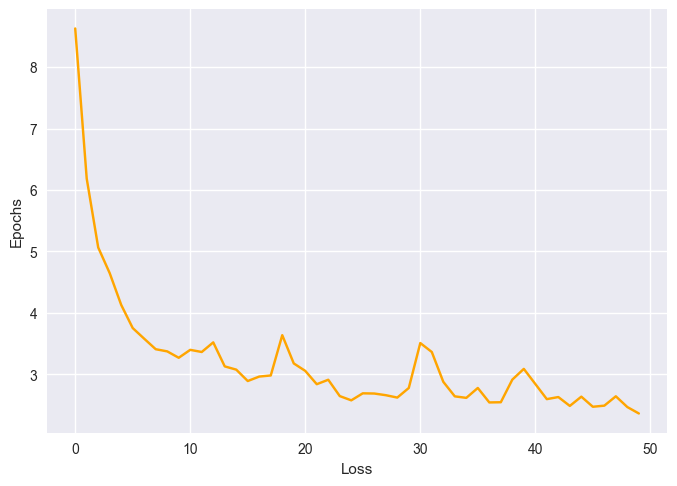

In [20]:
plt.plot(range(epochs), model.loss_history, color='orange')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.show()

In [22]:
test = one_hot_encode(word_to_idx['embedding'], len(word_to_idx))
# the test word is a python list so we need to transform it into a numpy array 
# with shape of 2 dimensional using the expand_dims() function 
test = np.expand_dims(np.array(test), 0)

result = model.predict(test)

probabilities = {
    idx_to_word[idx]: result[0][idx]
    for idx in np.argsort(result[0])[::-1]
}

probabilities

{'word': 0.2695655729724808,
 'a': 0.26706942822104507,
 'nlp': 0.20189778506039668,
 'is': 0.14679834895497545,
 'processing': 0.0423841180126899,
 'embedding': 0.03432841269033098,
 'matrix': 0.008050356059094781,
 'cooccurrence': 0.007219123978646058,
 'term': 0.006492888430992856,
 'on': 0.004130668182132627,
 'for': 0.0035562015237388073,
 'reduction': 0.0013176907260977653,
 'used': 0.0010841031947793891,
 'natural': 0.0006296353372476191,
 'meaning': 0.00059801740485638,
 'of': 0.0005411512358401025,
 'networksdimensionality': 0.00045959222908866914,
 'set': 0.00042544675462676657,
 'include': 0.0003684159516263278,
 'using': 0.00027616401968012604,
 'form': 0.0002761029822345577,
 'as': 0.00025156459643477057,
 'language': 0.00021157658372217693,
 'neural': 0.00020727248721613716,
 'such': 0.00018450749480527798,
 'realvalued': 0.00014176890661306496,
 'underlying': 0.00013780515834164878,
 'this': 0.0001253754125888213,
 'can': 0.00012330440731480523,
 'when': 0.00012214667397

In [23]:
def get_embedding(word, model):
    word_onehot = one_hot_encode(word_to_idx[word], len(word_to_idx))
    return np.dot(word_onehot, model.w1)


# get the embedding vector or the dense vector of the word 'machine' with 10 dimensional
get_embedding('embedding', model)

array([-1.14456481,  0.47677989,  2.36265608,  0.93780352,  1.2004058 ,
        1.16412415, -1.40945313,  0.05982977,  0.58405651, -0.35569287])